# Publishing Figures - Multi Kappa
This obtains all figures for a combining all simulations of differing optical depth that only require the surface variables.

In [189]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.utils.constants import L_v, c_p
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
from scipy.stats import median_abs_deviation
import matplotlib.transforms as mtransforms
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.utils.radiation import frierson_atmospheric_heating
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [190]:
# Load dataset
var_keep = ['temp', 'sphum', 'height']

# Don't include actual bucket, as looks very similar to bucket with vegetation param
exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
           'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
color_seq_exp = ['b', 'g', 'r']

kappa_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir[0])) if dir[0]=='k']
kappa_names.sort()
# kappa_names = kappa_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
n_kappa = len(kappa_names)
ds = [[] for i in range(n_exp)]
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_exp * n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir[i] + kappa_names[j])[var_keep]
            ds[i] += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
            namelist = isca_tools.load_namelist(exp_dir[i] + kappa_names[j])  # Need this for albedo_value
            if i == 0:
                albedo += [namelist['mixed_layer_nml']['albedo_value']]
                tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
                tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            pbar.update(1)
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0][0].pfull) * 100

100%|██████████| 24/24 [00:44<00:00,  1.83s/it]


## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [191]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

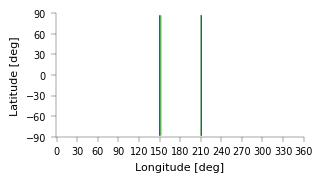

In [192]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir[1], kappa_names[0], 'land.nc')
# isca_tools.plot.show_land(land_file_name)
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

if save_fig or save_land_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [193]:
# Load in across all latitudes, for given season
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20

mean_method = 'land'
# mean_method = 'all'

lat_use_ind = np.where((np.abs(ds[0][0].lat) <= lat_max) & (np.abs(ds[0][0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0][0].lat))[lat_use_ind]

ds_all = [[] for i in range(n_exp)]
ds_mean = [[] for i in range(n_exp)]
with tqdm(total=n_exp * n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds[i][j].sel(time=slice(use_time_start, np.inf))
            ds_use = ds_use.isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
            
            if mean_method == 'all':
                ds_mean[i] += [ds_use.mean(dim=['lon', 'time']).load()]
            
            if 'aqua' not in exp_names[i].lower():
                # if not aquaplanet, then is land and only consider land longitudes
                ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
    
            if season == 'summer':
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_all[i] += [ds_use.load()]
            if mean_method == 'land':
                # Only take mean over land coordinates for land simulations
                # For aquaplanet, mean_method is irrelevant.
                ds_mean[i] += [ds_use.mean(dim='lon_time')]
            elif mean_method != 'all':
                raise ValueError(f'Mean method is {mean_method} which is not valid.')
            pbar.update(1)

100%|██████████| 24/24 [03:42<00:00,  9.29s/it]


## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [194]:
# Need to choose quantile method, use 'temp' for comparison with land.
# quant_method = 'byrne'      # var_quant2 will be the x percentile of var (as in Byrne 2021)
quant_method = 'temp'       # var_quant2 will be the average of var conditioned on the days with x percentile of temperature

if quant_method == 'byrne':
    label_quant = 'Percentile, $x$'
elif quant_method == 'temp':
    label_quant = 'Temperature percentile, $x$'
else:
    raise ValueError('quant_method is not valid')

# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quantiles_all = np.arange(1, 100)   # avoid 0 quantile as it gives weird results
n_quant_all = len(quantiles_all)     

temp_mean = np.zeros((n_exp, n_kappa, n_lat))
sphum_mean = np.zeros((n_exp, n_kappa, n_lat))
mse_mean = np.zeros((n_exp, n_kappa, n_lat))
r_mean = np.zeros((n_exp, n_kappa, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_kappa, n_lat, n_quant_all))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_kappa, n_lat, n_quant_all))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_kappa, n_lat, n_quant_all))

with tqdm(total=n_exp*n_kappa*n_quant_all*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds_mean[i][j]
            temp_mean[i, j] = ds_use.temp
            sphum_mean[i, j] = ds_use.sphum
            mse_mean[i, j] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
        
            ds_use = ds_all[i][j]
            temp_quant2[i, j] = ds_use.temp.quantile(quantiles_all/100, dim='lon_time', keep_attrs=True).transpose()
            mse = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
            if quant_method == 'byrne':
                sphum_quant2[i, j] = ds_use.sphum.quantile(quantiles_all/100, dim='lon_time', keep_attrs=True).transpose()
                mse_quant2[i, j] = ds_use.quantile(quantiles_all/100, dim='lon_time', keep_attrs=True).transpose()
                pbar.update(n_quant_all*n_lat)
            elif quant_method == 'temp':
                for k in range(n_lat):
                    for q, quant in enumerate(quantiles_all):
                        use_ind = get_quant_ind(ds_use.temp[k], quant, 0.5, 0.5)
                        sphum_quant2[i, j, k, q] = ds_use.sphum[k, use_ind].mean()
                        mse_quant2[i, j, k, q] = mse[k, use_ind].mean()
                        pbar.update(1)

100%|██████████| 33264/33264 [02:17<00:00, 241.24it/s]


In [195]:
# For given quantiles, plot quantile vs average temp for each latitude.
# Then fit best line to this to get simulated gradient, combining all kappa values
quant_plot = [90, 95, 99]
quant_plot = [1, 25, 50, 75, 99]
quant_plot_ind = numpy_indexed.indices(quantiles_all, quant_plot)
n_quant_plot = len(quant_plot)

def get_gradient(temp_quant, temp_av, ref_ind):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int

    Returns:
        int
            Gradient
        [n_exp]
            Predicted temperature for each experiment
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[0]
    return param, fit_func(temp_av, param)

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
temp_quant_grad = np.zeros((n_exp, n_lat, n_quant_plot))
temp_quant_grad_fit = np.zeros((n_exp, n_kappa, n_lat, n_quant_plot))
for k in range(n_exp):
    for i in range(n_lat):
        for j in range(n_quant_plot):
            temp_quant_grad[k, i, j], temp_quant_grad_fit[k, :, i, j] = get_gradient(temp_quant2[k, :, i, quant_plot_ind[j]],
                                                                               temp_mean[k, :, i], tau_ref_ind)

## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

Gradient of best fit line for Aquaplanet [1, 25, 50, 75, 99] percentiles: [1.09 1.04 0.99 0.95 0.96]


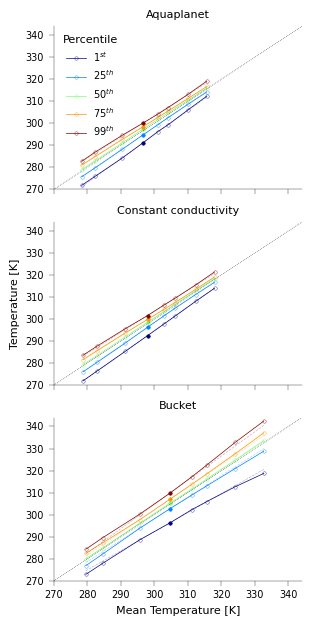

In [196]:
trend_line_on = True
save_trend_fig = False

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]

temp_mean_weight = np.average(temp_mean, axis=2, weights=lat_weights)
temp_quant_weight = np.average(temp_quant2, axis=2, weights=lat_weights)
color_seq_quant = plt.cm.jet(np.linspace(0,1,n_quant_plot))

# labels_quant = [f'{qu}$^{st}$', '25$^{th}$', '50$^{th}$', '75$^{th}$', '99$^{th}$']
fig, ax = plt.subplots(n_exp,1, figsize=(width['one_col'], n_exp*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[i].set_title(exp_names[i])
    for j in range(n_quant_plot):
        ax[i].plot(temp_mean_weight[i],
                temp_quant_weight[i, :, quant_plot_ind[j]],
                marker='o',
                label=f'{quant_plot[j]}'+ ('$^{st}$' if quant_plot[j]==1 else '$^{th}$'),
                color=color_seq_quant[j], fillstyle='none')
        if trend_line_on:
            # Filled circle for reference simulation
            ax[i].plot(temp_mean_weight[i, tau_ref_ind],
                    temp_quant_weight[i, tau_ref_ind, quant_plot_ind[j]],
                    marker='o', color=color_seq_quant[j], fillstyle='full')
            if j==n_quant_plot-1:
                label = None #'Linear fits'
            else:
                label = None
            ax[i].plot(temp_mean_weight[i],
                    np.average(temp_quant_grad_fit[i, :, :, j], axis=1, weights=lat_weights),
                    linestyle='--', color=color_seq_quant[j], alpha=0.3, label=label)
for i in range(n_exp):
    # xlim = ax[i].get_xlim()
    # ylim = ax[i].get_ylim()
    lim_new = [270, 344]
    ax[i].plot(lim_new, lim_new, 'k:', alpha=0.75)
    if i == 0:
        ax[i].set_ylim(lim_new)
        ax[i].set_xlim(lim_new)
if trend_line_on:
    ax[0].legend(loc='upper left', title='Percentile')
ax[-1].set_xlabel(f'Mean Temperature [K]')
ax[1].set_ylabel(f'Temperature [K]')
if save_fig or save_trend_fig:
    if trend_line_on:
        file_name = f"{region.lower()}_trend"
    else:
        file_name = f"{region.lower()}_no_trend"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight',
                pad_inches=save_pad_inches)
print(f'Gradient of best fit line for {exp_names[0]} {quant_plot} percentiles: {np.round(np.average(temp_quant_grad[0], weights=lat_weights, axis=0), 2)}')

## Theory for Temperature change relative to median change between subsequent $\kappa$
The below shows the predicted amplification factor compared to the actual one. The denominator in $\delta T(x)/\delta \overline{T}$ is the change in the median temperature as the theory can predict this too.

In [197]:
delta_mse_ratio = np.diff(mse_quant2, axis=1)/np.expand_dims(np.diff(mse_mean, axis=1), axis=-1)
# delta_temp_quant_theory[-1] will be all zeros and never used, but helpful to keep this shape
delta_temp_quant_theory = {method: np.zeros((n_exp, n_kappa, n_lat, n_quant_all)) for method in
                           ['linear', 'const_rh', 'squared', 'squared_lambda', 'lambda', 'linear_full']}
for method in delta_temp_quant_theory:
    for j in range(n_exp):
        for i in range(n_lat):
            delta_temp_quant_theory[method][j, :-1, i] = \
                    get_delta_temp_quant_theory(temp_mean[j, :, i], sphum_mean[j, :, i], temp_quant2[j, :, i], sphum_quant2[j, :, i], p_surface,
                                                const_rh=True if method=='const_rh' else False,
                                                delta_mse_ratio=delta_mse_ratio[j, :, i] if 'lambda' in method else None,
                                                taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')
            delta_temp_quant_theory['linear_full'][j, :-1, i] = \
                    get_delta_temp_quant_theory(temp_mean[j, :, i], sphum_mean[j, :, i], temp_quant2[j, :, i], sphum_quant2[j, :, i], p_surface,
                                                const_rh=False, delta_mse_ratio=None, taylor_level='linear')

In [198]:
scaling_factor_av = 'mean'    # Mean will use quantile closest to mean at each latitude
# scaling_factor_av = 'median'  # take median as average rather than mean because theory does not predict change to mean temperature
# scaling_factor_av_type = 'theory'
scaling_factor_av_type = 'simulated'     # If 'simulated', will use theoretical mean/median temp diff to compute theoretical scale factor too

# get theory predictions for all quantiles
# delta_temp_quant[:, -1] will be all zeros and never used, but helpful to keep this shape
delta_temp_quant = np.zeros((n_exp, n_kappa, n_lat, n_quant_all))
delta_temp_quant[:, :n_kappa-1, :, :] = np.diff(temp_quant2, axis=1)

if scaling_factor_av == 'mean':
    av_quant_ind = np.zeros((n_exp, n_kappa, n_lat))
    for k in range(n_exp):
        for i in range(n_kappa):
            for j in range(n_lat):
                av_quant_ind[k, i, j] = scipy.stats.percentileofscore(ds_all[k][i].temp[j], float(ds_all[k][i].temp[j].mean()))
    av_quant_ind = np.round(av_quant_ind).astype(int)
    delta_temp_sf_av = np.diff(temp_mean, axis=1)
for k in range(n_exp):
    for i in range(n_exp):
        # Get position of index in array
        av_quant_ind[k, i] = numpy_indexed.indices(quantiles_all, av_quant_ind[k, i])

# exp_flat_ind, lat_flat_ind = np.unravel_index(np.arange(np.prod(av_quant_ind.shape)), av_quant_ind.shape)
# av_quant_flat_ind = np.ravel_multi_index((exp_flat_ind, lat_flat_ind, av_quant_ind.flatten()), (n_exp, n_lat, n_quant_all))

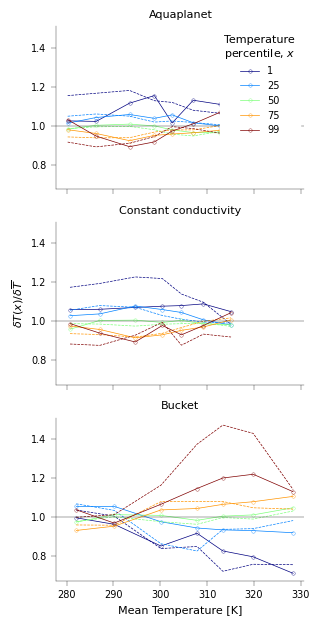

In [199]:
theory_method = 'linear'
color_seq = plt.cm.jet(np.linspace(0,1,len(quant_plot)))

save_amp_factor_fig=False
fig, ax = plt.subplots(n_exp,1, figsize=(width['one_col'], n_exp * width['one_col']/ar), sharey=True, sharex=True)
for i in range(n_exp):
    ax[i].set_title(exp_names[i])
    for j in range(n_quant_plot):
        # for difference between simulations, make x-axis the average between the two mean temperatures
        ax[i].plot(moving_average(temp_mean_weight[i], 2), 
                   np.average(delta_temp_quant[i, :-1, :, quant_plot_ind[j]]/delta_temp_sf_av[i], axis=1, weights=lat_weights), 
                   color=color_seq[j], marker='o', fillstyle='none', label=quant_plot[j])
        if scaling_factor_av_type == 'simulated':
            denom_use = delta_temp_sf_av[i]
        else:
            raise ValueError('Need to add the av_quant_flat_ind stuff for this')
            # denom_use = delta_temp_quant_theory[theory_method].flatten()[av_quant_flat_ind].reshape((n_exp, n_lat))[:-1]
        ax[i].plot(moving_average(temp_mean_weight[i], 2),
                np.average(delta_temp_quant_theory[theory_method][i, :-1, :, quant_plot_ind[j]]/denom_use,
                           axis=1, weights=lat_weights), color=color_seq[j], linestyle='--')
ax[0].legend(title='Temperature\npercentile, $x$', frameon=True, framealpha=1, edgecolor='w')
xlim = ax[0].get_xlim()
for i in range(n_exp):
    ax[i].hlines(1, xlim[0], xlim[1], color='k', linewidth=ax_linewidth)
ax[0].set_xlim(xlim)
ax[-1].set_xlabel(f'Mean Temperature [K]')
ax[1].set_ylabel('$\delta T(x)/\delta \overline{T}$')
if save_fig or save_amp_factor_fig:
    file_name = f'{region.lower()}_amplification_factor_{theory_method}'
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf", dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

## Figure 2 of Byrne 2021 - combining $\kappa$
The plot below indicates is found by plotting temp_quant vs temp_median (one marker for each $\kappa$) and the taking the gradient. I do this for each quantile, so I obtain a single value for each quantile.

I am using the actual percentile (not the average over a given percentile as used in Byrne 2021).

To see if the scaling factor is different for warmer vs colder climates, I compute the gradients using a subset of $\kappa$ values. For colder climates, I use $\kappa=0.2, 0.3, 0.6, 1$ and force the line through $\kappa=1$. For warmer climates, I use $\kappa=1, 1.5, 2, 3.5, 6$ and force the line through $\kappa=1$. The solid line includes all $\kappa$ and is forced through $\kappa = 1$.

I also do the same with the theoretical temperature. To get the theoretical temperature, I start with the simulated temperature for the coldest simulation, and then add the theoretical temperature difference.

In [200]:
# theory2 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory2 = {method: temp_quant2.copy() for method in ['linear', 'const_rh', 'squared', 'squared_lambda', 'lambda', 'linear_full']}
for method in delta_temp_quant_theory:
    for i in range(n_exp):
        for j in range(n_kappa-1):
            temp_quant_theory2[method][i, 1+j] = temp_quant_theory2[method][i, j] + delta_temp_quant_theory[method][i, j]

In [201]:
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]
n_sf = len(sf_tau_use)
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = np.zeros((n_exp, n_sf, n_lat, n_quant_all))

scaling_factor_theory = {method: np.zeros((n_exp, n_sf, n_lat, n_quant_all)) for method in delta_temp_quant_theory}

# Set all theoretical mean predictions to the simulated
sf_av = {key: temp_mean for key in temp_quant_theory2.keys()}
if scaling_factor_av == 'mean':
    sf_av['simulated'] = temp_mean
else:
    raise ValueError('Need to add temp_median')
    # sf_av['simulated'] = temp_median

with tqdm(total=n_exp*n_sf*n_quant_all*n_lat, position=0, leave=True) as pbar:
    for ii in range(n_exp):
        for i in range(n_sf):
            sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
            for j in range(n_quant_all):
                # The theory predicts median change but not mean hence I use median rather than mean.
                # This means can get theoretical scale factor rather than using simulated mean.
                # This means x=50 will correspond to y=1 in all plots below.
                # Straight line through the ref point
                for k in range(n_lat):
                    scaling_factor[ii, i, k, j] = get_gradient(temp_quant2[ii, sf_tau_use[i], k, j], 
                                                               sf_av['simulated'][ii, sf_tau_use[i], k], sf_tau_ref_ind)[0]
                    for method in scaling_factor_theory:
                        # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                        scaling_factor_theory[method][ii, i, k, j] = get_gradient(temp_quant_theory2[method][ii, sf_tau_use[i], k, j],
                                                                                  sf_av[method][ii, sf_tau_use[i], k], sf_tau_ref_ind)[0]
                    pbar.update(1)

100%|██████████| 12474/12474 [00:07<00:00, 1577.53it/s]


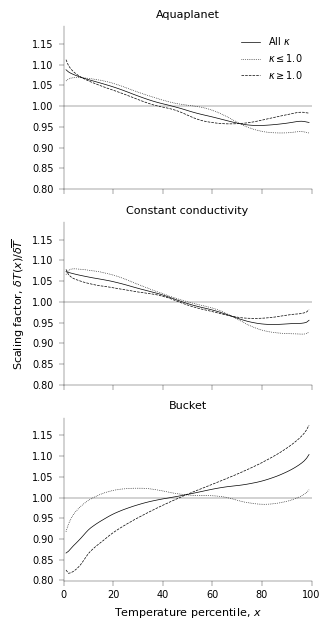

In [202]:
save_sf_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(n_exp,1, figsize=(width['one_col'], n_exp * width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_exp):
    ax[i].plot(quantiles_all, np.average(scaling_factor[i, 0], axis=0, weights=lat_weights), color='k', label='All $\kappa$')
    ax[i].plot(quantiles_all, np.average(scaling_factor[i, 1], axis=0, weights=lat_weights), color='k', linestyle=':',
            label=f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
    ax[i].plot(quantiles_all, np.average(scaling_factor[i, 2], axis=0, weights=lat_weights), color='k', linestyle='--',
            label= f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
    ax[i].hlines(1, 0, 100, lw=ax_linewidth, color='k')
    ax[i].set_title(exp_names[i])
    # # Remove some of the lines but keep ylims the same
    # ax[i].lines.pop(1)
    # ax[i].lines.pop(1)
ax[0].legend()
ax[0].set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[1].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_multi_kappa_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf", dpi=dpi['monochrome'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

The solid blue line below is the same as the solid black line above. The black lines show the theoretical prediction for the blue line, combining all kappa values.

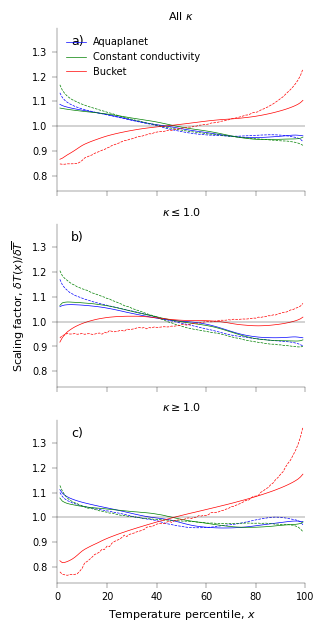

In [210]:
save_multi_sf_theory_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(n_sf,1, figsize=(width['one_col'], n_sf * width['one_col']/ar), sharey=True, sharex=True)
for i in range(n_sf):
    for j in range(n_exp):
        ax[i].plot(quantiles_all, np.average(scaling_factor[j, i], axis=0, weights=lat_weights), color=color_seq_exp[j], label=exp_names[j])
        ax[i].plot(quantiles_all, np.average(scaling_factor_theory['linear'][j, i], axis=0, weights=lat_weights), 
                   color=color_seq_exp[j], linestyle='--')
    ax[i].hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax[0].set_title(f'All $\kappa$')
ax[1].set_title(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax[2].set_title(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(2)
# ax.lines.pop(1)
ax[0].legend()
ax[0].set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[1].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
label_subplots(fig, ax)
if save_fig or save_multi_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

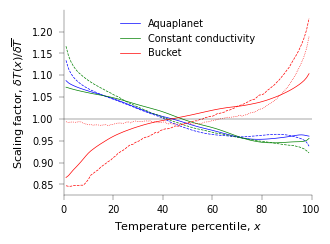

In [209]:
# if publishing figure, use high dpi
save_sf_theory_fig = False
sf_ind_use = 0  # 0, 1 or 2
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for j in range(n_exp):
    ax.plot(quantiles_all, np.average(scaling_factor[j, sf_ind_use], axis=0, weights=lat_weights), color=color_seq_exp[j], label=exp_names[j])
    ax.plot(quantiles_all, np.average(scaling_factor_theory['linear'][j, sf_ind_use], axis=0, weights=lat_weights), 
               color=color_seq_exp[j], linestyle='--')
    if 'bucket' in exp_names[j].lower():
        # Show both theories for the bucket simulations
        ax.plot(quantiles_all, np.average(scaling_factor_theory['const_rh'][j, sf_ind_use], axis=0, weights=lat_weights), 
               color=color_seq_exp[j], linestyle=':')
ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend()
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

## Approximations of Theory
Below, I investigate the 3 approximations that go into the aquaplanet theory.

In [205]:
lambda_p = {var: np.zeros((n_exp, n_sf, n_lat, n_quant_all)) for var in ['temp', 'sphum', 'mse', 'mse2']}

for ii in range(n_exp):
    for i in range(n_sf):
        sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
        for j in range(n_quant_all):
            # The theory predicts median change but not mean hence I use median rather than mean.
            # This means can get theoretical scale factor rather than using simulated mean.
            # This means x=50 will correspond to y=1 in all plots below.
            # Straight line through the ref point
            for k in range(n_lat):
                lambda_p['temp'][ii, i, k, j] = get_gradient(temp_quant2[ii, sf_tau_use[i], k, j],
                                                             temp_mean[ii, sf_tau_use[i], k], sf_tau_ref_ind)[0]
                lambda_p['sphum'][ii, i, k, j] = get_gradient(sphum_quant2[ii, sf_tau_use[i], k, j], 
                                                              sphum_mean[ii, sf_tau_use[i], k], sf_tau_ref_ind)[0]
                lambda_p['mse'][ii, i, k, j] = get_gradient(mse_quant2[ii, sf_tau_use[i], k, j], 
                                                            mse_mean[ii, sf_tau_use[i], k], sf_tau_ref_ind)[0]
                lambda_p['mse2'][ii, i, k, j] = get_gradient(c_p * temp_quant2[ii, sf_tau_use[i], k, j] + 
                                                             L_v * sphum_quant2[ii, sf_tau_use[i], k, j], 
                                                             c_p * temp_mean[ii, sf_tau_use[i], k] + 
                                                             L_v * sphum_mean[ii, sf_tau_use[i], k], sf_tau_ref_ind)[0]

## Bucket Model Specific Plots

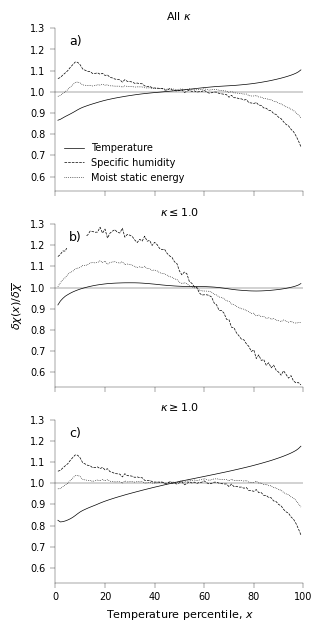

In [206]:
bucket_ind = 2

save_lambda_multi_fig = False
fig, ax = plt.subplots(n_sf,1, figsize=(width['one_col'], n_sf * width['one_col']/ar), sharey=True, sharex=True)
labels = ['Temperature','Specific humidity', 'Moist static energy']
linestyles = ['-', '--', ':']
for i in range(n_sf):
    for j, var in enumerate(['temp', 'sphum', 'mse']):
        ax[i].plot(quantiles_all, np.average(lambda_p[var][bucket_ind, i], axis=0, weights=lat_weights), 
                   label=labels[j], linestyle=linestyles[j], color='k')
    ax[i].hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax[0].legend(loc='lower left')
ax[0].set_title(f'All $\kappa$')
ax[1].set_title(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax[2].set_title(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
ax[-1].set_xlabel('Percentile, $x$' if quant_method == 'byrne' else 'Temperature percentile, $x$')
ax[1].set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
ax[0].set_ylim(0.53,1.3)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax)
# plt.tight_layout()
if save_fig or save_lambda_multi_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_multi_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

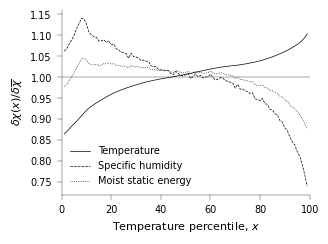

In [207]:
# Do the same as above, but just showing just one kappa range
save_lambda_fig = False
bucket_ind=2
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for j, var in enumerate(['temp', 'sphum', 'mse']):
    ax.plot(quantiles_all, np.average(lambda_p[var][bucket_ind, sf_ind_use], axis=0, weights=lat_weights), 
               label=labels[j], linestyle=linestyles[j], color='k')
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
ax.set_xlabel('Percentile, $x$' if quant_method == 'byrne' else 'Temperature percentile, $x$')
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

There are three approximations that go into the theory:
1. $\lambda = \delta h(x)/\delta \overline{h} = 1$

    The validity of this is shown by the green line in the $\delta Ocean/\delta \overline{Ocean}$ plot above. This should be equal to 1.
    In the plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown by comparing the green lines in the $\delta Ocean/\delta \overline{Ocean}$ plot above. If this approximation was exact, we would expect them to match up exactly.
   In the plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (blue line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$ as well as for $\delta \overline{q}$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

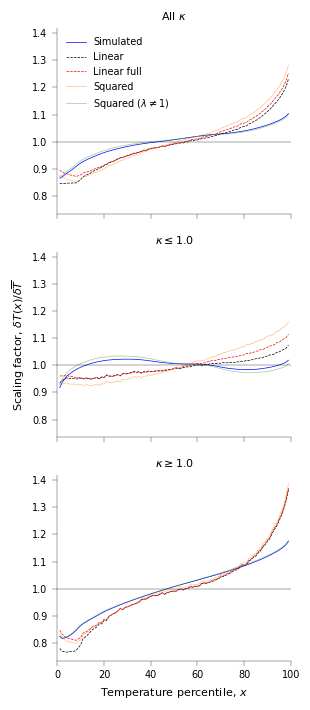

In [208]:
save_approx_fig = False
fig, ax = plt.subplots(n_sf,1, figsize=(width['one_col'], n_sf*width['one_col']/ar), sharey=True, sharex=True)

for i in range(n_sf):
    ax[i].plot(quantiles_all, np.average(scaling_factor[bucket_ind, i], axis=0, weights=lat_weights), label = 'Simulated', color='b')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['linear'][bucket_ind, i], axis=0, weights=lat_weights),
               label='Linear', color='k', linestyle='--')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['linear_full'][bucket_ind, i], axis=0, weights=lat_weights),
               label='Linear full', color='r', linestyle='--')
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['squared'][bucket_ind, i], axis=0, weights=lat_weights),
               label='Squared', color=default_colors[1], alpha=0.5)
    ax[i].plot(quantiles_all, np.average(scaling_factor_theory['squared_lambda'][bucket_ind, i], axis=0, weights=lat_weights),
               label='Squared ($\lambda \\neq 1$)', color=default_colors[2], alpha=0.5)
    ax[i].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].set_title(f'All $\kappa$')
ax[1].set_title(f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax[2].set_title(f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
ax[0].legend()
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[1].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[0].set_xlim(0,100)
plt.tight_layout()

if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/scaling_factor_approx_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)